In [158]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return

In [107]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "MSFT", "AAPL", "AMD"] # Initial asset universe
start_date = '2013-01-01'
end_date = '2024-01-01'

In [113]:
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
data.to_csv("./Data/historical_data.csv")

market_returns = np.log(data / data.shift(1)).dropna()
# etf_data['Returns'] = np.log(etf_data['Close'] / etf_data['Close'].shift(1))

# closing_prices = data["Adj Close"]

def get_market_prices_and_caps(tickers, start_date, end_date):
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

# closing_prices.tail()
data.tail()

[*********************100%***********************]  7 of 7 completed


Ticker,AAPL,AMD,AMZN,META,MSFT,NVDA,TSLA
Date,,,,,,,
2023-12-22 00:00:00+00:00,192.656174,139.600006,153.419998,352.329163,371.799744,48.819527,252.539993
2023-12-26 00:00:00+00:00,192.108856,143.410004,153.410004,353.764832,371.879120,49.268425,256.609985
2023-12-27 00:00:00+00:00,192.208359,146.070007,153.339996,356.755859,371.293518,49.406395,261.440002
2023-12-28 00:00:00+00:00,192.636276,148.759995,153.380005,357.244415,372.494507,49.511375,253.179993
2023-12-29 00:00:00+00:00,191.591400,147.410004,151.940002,352.897491,373.248871,49.511375,248.479996


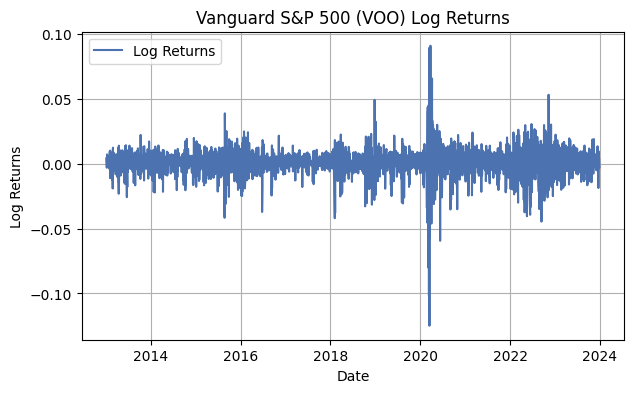

In [120]:
def plot_log_returns(etf_data):
    plt.figure(figsize=(7,4))
    plt.plot(etf_data.index, etf_data['Returns'], label='Log Returns')
    plt.title('Vanguard S&P 500 (VOO) Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

plot_log_returns(etf_data)

In [124]:
def fit_markov_switching(data):
    model = MarkovRegression(data, k_regimes=2, switching_variance=True)
    results = model.fit
    return results

In [141]:
def set_view_confidences_for_views(results, markov_relative_views, threshold_bull=0.6, threshold_bear=0.4):
    smoothed_probs = results.smoothed_marginal_probabilities
    
    view_confidences = []
    
    # check views matches a valid range
    if len(markov_relative_views) > len(smoothed_probs[0]):
        raise ValueError("Number of views exceeds the number of time steps in smoothed probabilities.")
    
    # Iterate over views and assign confidences
    for idx in range(len(markov_relative_views)):
        bull_prob = smoothed_probs[0][idx]
        bear_prob = smoothed_probs[1][idx]
        
        if bull_prob > threshold_bull:
            confidence = bull_prob
        elif bear_prob > threshold_bear:
            confidence = bear_prob
        else:
            confidence = max(bull_prob, bear_prob)
        
        view_confidences.append(confidence)
    
    return view_confidences

markov_adjusted_confidences = set_view_confidences_for_views(results, markov_relative_views, threshold_bull=0.6, threshold_bear=0.4)
markov_adjusted_confidences


C:\Users\chana\AppData\Local\Temp\ipykernel_16172\1757996301.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bull_prob = smoothed_probs[0][idx]
C:\Users\chana\AppData\Local\Temp\ipykernel_16172\1757996301.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bear_prob = smoothed_probs[1][idx]


[0.9873351935921961,
 0.9946124193937221,
 0.9970965794139546,
 0.9981035174866538,
 0.9986383135957029]

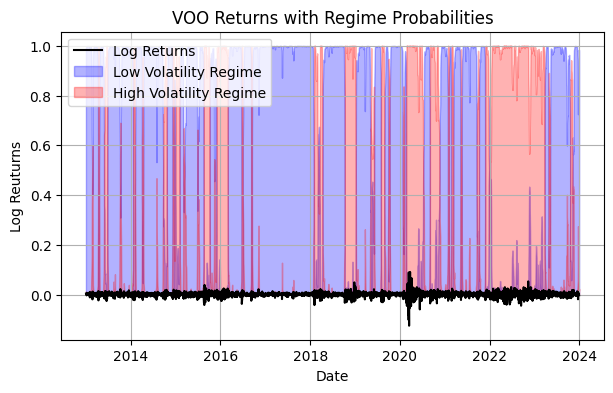

In [ ]:
# To visalise when the market is in bull/bear periods. 
# can see the likelihood of each one occuring using smoothed probabilities
def plot_regime_probabilities(etf_data):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(etf_data. index, etf_data['Returns'], label='Log Returns', color='black')
    
    ax.fill_between(etf_data.index, 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='Low Volatility Regime')
    ax.fill_between(etf_data.index, 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='High Volatility Regime') # Any red sections show the market in high volatility period

    ax.set_title('VOO Returns with Regime Probabilities')
    ax.set_xlabel('Date')
    ax.set_ylabel("Log Reuturns")
    plt.grid()
    ax.legend(loc='upper left')
    plt.show()

plot_regime_probabilities(etf_data)

<Axes: >

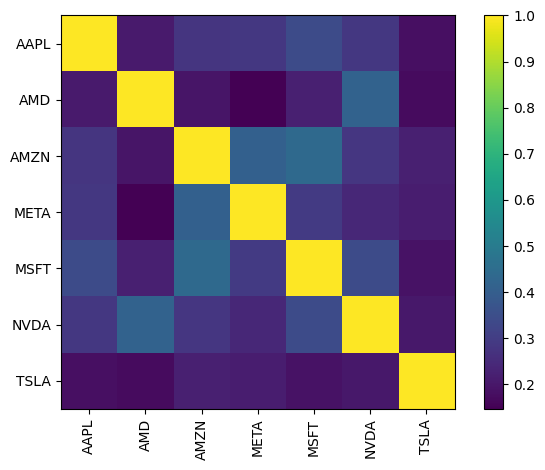

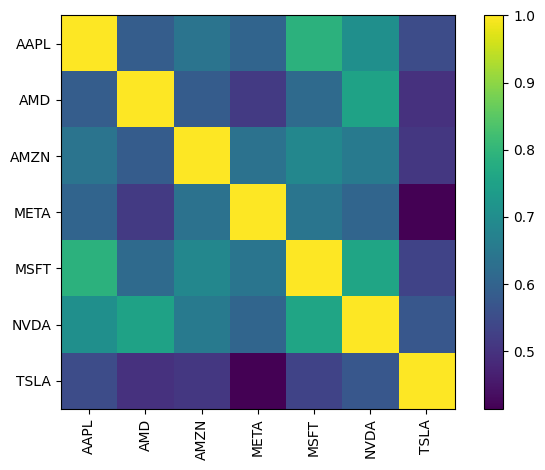

In [142]:
plotting.plot_covariance(regime_0_cov, plot_correlation=True) # low volatility
plotting.plot_covariance(regime_1_cov, plot_correlation=True) # high volatility

In [127]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)

markov_delta = black_litterman.market_implied_risk_aversion(market_prices)
markov_prior = black_litterman.market_implied_prior_returns(market_caps, markov_delta, average_dynamic_cov)

markov_prior

[*********************100%***********************]  1 of 1 completed


TSLA    0.020946
NVDA    0.022274
AMZN    0.021139
META    0.021209
MSFT    0.021017
AAPL    0.021888
AMD     0.021354
dtype: float64

In [144]:
# old markov_view_confidences = [0.3, 0.9, 0.4, 0.5, 0.2, 0.6, 0.7]
markov_relative_views = np.array([0.20, 0.15, 0.10, 0.07, 0.25]).reshape(-1, 1)

picking_matrix = np.array(
    [
        # five views (rows) and seven assets (columns)
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, -1, 0, 0],
        [0, 0, -1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1] # dont think these are mapped correctly
    ]
)

markov_bl = BlackLittermanModel(regime_0_cov, pi=markov_prior, absolute_views=None, Q=markov_relative_views, P=picking_matrix, omega="idzorek", view_confidences=markov_adjusted_confidences)

markov_bl_returns = markov_bl.bl_returns()
markov_bl_returns

Ticker
AAPL    0.197813
AMD     0.208053
AMZN    0.047770
META    0.147518
MSFT    0.058749
NVDA    0.070150
TSLA    0.249777
dtype: float64

In [152]:
markov_relative_views_series = pd.Series(np.nan, index=tickers)
markov_relative_views_series[:len(markov_relative_views)] = markov_relative_views.flatten()

markov_returns_df = pd.DataFrame([markov_prior, markov_bl_returns, pd.Series(markov_relative_views_series)], index=["Prior", "Posterior", "Views"]).T
markov_returns_df

,Prior,Posterior,Views
TSLA,0.020946,0.249777,0.20
NVDA,0.022274,0.070150,0.15
AMZN,0.021139,0.047770,0.10
META,0.021209,0.147518,0.07
MSFT,0.021017,0.058749,0.25
AAPL,0.021888,0.197813,NaN
AMD,0.021354,0.208053,NaN


<Axes: >

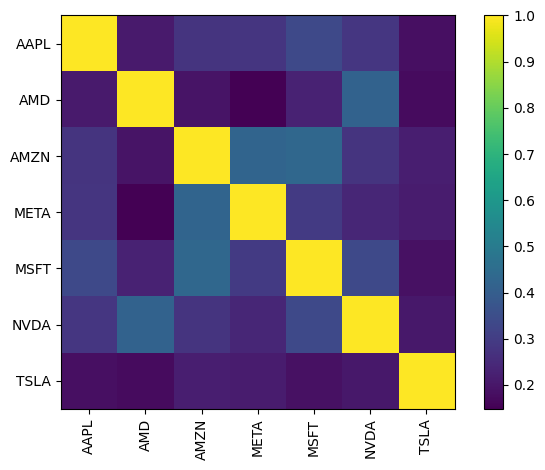

In [153]:
markov_posterior_cov = markov_bl.bl_cov()
plotting.plot_covariance(markov_posterior_cov, plot_correlation=True)

In [ ]:
markov_ef = EfficientFrontier(markov_bl_returns, markov_posterior_cov)
markov_max_sharpe = markov_ef.max_sharpe()
markov_cleaned_weights = markov_ef.clean_weights()
markov_cleaned_weights

OrderedDict([('AAPL', 0.70026),
             ('AMD', 0.05646),
             ('AMZN', 0.0),
             ('META', 0.12189),
             ('MSFT', 0.0),
             ('NVDA', 0.0),
             ('TSLA', 0.12138)])

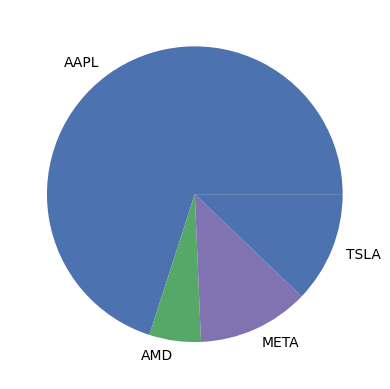

In [156]:
model_3_allocations = pd.Series(markov_cleaned_weights).plot.pie()

In [157]:
markov_ef.portfolio_performance(verbose=True)

Expected annual return: 19.9%
Annual volatility: 1.2%
Sharpe Ratio: 14.31


(0.198567817148597, 0.012481701694364859, 14.306367955357835)

In [ ]:
latest_prices = get_latest_prices(data)
da = DiscreteAllocation(markov_cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

{'AAPL': 37, 'AMD': 4, 'META': 3, 'TSLA': 5}
